### REI505M Final project: Music genre classification starter pack

The following Dataset class operates on the GTZAN dataset.

* The duration of most GTZAN files are 30 seconds (3022050=661500 samples) but some are slightly shorter (approx 29.9 seconds). For this reason we truncate at 660000 samples below.
* It may be beneficial to work with smaller chunks than ~30 seconds.
* You may want to perform the data augmentations in the `__get_item__` function.
* For now, `train_dataset` contains all the dataset, you need to set aside some examples for validation and test sets.

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import scipy.io.wavfile as wav
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import librosa
import numpy as np

audio_dir = 'data/music/' # Path to folder with GTZAN files
# music/
#  - rock/
#       rock.00099.wav
#       ...
#  - reggie/
#  ...
#  - blues/

batch_size = 32

class AudioDataset(Dataset):
    def __init__(self, audio_files, labels, audio_path,
                 maxlen, sampling_rate, duration, is_train=False):
        self.audio_files = audio_files
        self.audio_path = audio_path
        self.labels = labels
        self.maxlen = maxlen
        self.sampling_rate = sampling_rate
        self.duration = duration
        self.is_train = is_train

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        label = self.labels[idx]
        audio_file = self.audio_files[idx]
        audio_dir = audio_file[:audio_file.index('.')]
        file_path = os.path.join(self.audio_path, audio_dir, audio_file)
        (rate, audio_samples) = wav.read(file_path)
        audio_samples = audio_samples.astype('float32') / 32768.0  # Normalize to [-1, 1]

        # Truncate early if too long
        if len(audio_samples) > self.maxlen:
            audio_samples = audio_samples[:self.maxlen]

        # Random offset for variety
        target_len = int(self.sampling_rate * self.duration)
        max_start = max(0, len(audio_samples) - target_len)
        tstart = np.random.randint(0, max_start + 1) if max_start > 0 else 0
        audio_samples = audio_samples[tstart:tstart + target_len]

        # Pad if shorter than target_len
        if len(audio_samples) < target_len:
            audio_samples = np.pad(audio_samples, (0, target_len - len(audio_samples)), mode='constant')

        # Apply random augmentations with some probability
        if self.is_train and np.random.rand() < 0.5:  # 50% chance
            # Pitch shift (preserves length)
            audio_samples = librosa.effects.pitch_shift(audio_samples, sr=self.sampling_rate, n_steps=np.random.uniform(-2, 2))

            # Time stretch (changes length, so stretch then resample to original length)
            original_len = len(audio_samples)
            rate = np.random.uniform(0.8, 1.2)
            stretched = librosa.effects.time_stretch(audio_samples, rate=rate)
            audio_samples = librosa.resample(stretched, orig_sr=self.sampling_rate, target_sr=self.sampling_rate * (original_len / len(stretched)))

            # Add noise
            noise = np.random.randn(len(audio_samples)) * 0.005
            audio_samples += noise

            # Clip to [-1, 1]
            audio_samples = np.clip(audio_samples, -1, 1)

        # Enforce exact target_len after augmentations
        if len(audio_samples) > target_len:
            audio_samples = audio_samples[:target_len]
        elif len(audio_samples) < target_len:
            audio_samples = np.pad(audio_samples, (0, target_len - len(audio_samples)), mode='constant')

        # Convert to torch
        audio_samples = torch.from_numpy(audio_samples).float()

        return audio_samples, label

label_map={'blues' : 0, 'classical' : 1, 'country' : 2,
           'disco' : 3, 'hiphop'    : 4, 'jazz'    : 5,
           'metal' : 6, 'pop'       : 7, 'reggae'  : 8, 'rock' : 9}

audio_files = []
labels = []
for root, subdirs, files in os.walk(audio_dir):
    for fname in files:
        if fname == '.DS_Store':
            continue
        audio_files.append(fname)
        labels.append(label_map[fname[:fname.index('.')]])

torch.manual_seed(0) # Reproducible results

# Create validation and test sets
train_files, temp_files, train_labels, temp_labels = train_test_split(
    audio_files, labels, test_size=0.3, stratify=labels, random_state=42
)

# Split temp into val and test
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print("Training set:", len(train_files))
print("Validation set:", len(val_files))
print("Test set:", len(test_files))
assert len(set(train_files) & set(val_files) & set(test_files)) == 0

train_dataset = AudioDataset(audio_files=train_files, labels=train_labels,
                             audio_path=audio_dir, 
                             maxlen=660000, sampling_rate=22050, duration=4)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create dataloaders for validation and test sets
sampling_rate = 22050
duration = 8  # reduced to 10 to finish training faster, max is 30
maxlen = 660000

train_dataset = AudioDataset(
    audio_files=train_files, labels=train_labels, audio_path=audio_dir,
    maxlen=maxlen, sampling_rate=sampling_rate, duration=duration, is_train=True
)

val_dataset = AudioDataset(
    audio_files=val_files, labels=val_labels, audio_path=audio_dir,
    maxlen=maxlen, sampling_rate=sampling_rate, duration=duration, is_train=False
)

test_dataset = AudioDataset(
    audio_files=test_files, labels=test_labels, audio_path=audio_dir,
    maxlen=maxlen, sampling_rate=sampling_rate, duration=duration, is_train=False
)

batch_size = 8 # Increase to 32 if your RAM/GPU can handle it
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tmp_features, tmp_labels = next(iter(train_loader))
print(f"Feature batch shape: {tmp_features.size()}")
print(f"Labels batch shape: {tmp_labels.size()}")

# define 1D CNN model
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(2, stride=2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        return x

class AudioClassifier(nn.Module):
    def __init__(self, r=3, kernel_size=5, M=256, input_length=int(22050 * 8)): # can reduce r to 3 for faster training
        super().__init__()
        self.blocks = nn.ModuleList()
        in_channels = 1
        out_channels = 16
        for _ in range(r):
            self.blocks.append(ConvBlock(in_channels, out_channels, kernel_size))
            in_channels = out_channels
            out_channels *= 2

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Compute fdim with dummy input
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            x = dummy
            for block in self.blocks:
                x = block(x)
            x = self.global_pool(x)
            fdim = x.numel()  # Flattened size
        
        self.fc1 = nn.Linear(fdim, M)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(M, 10)

    def forward(self, x):
        # Input: (batch, 1, seq_len) since audio is 1 channel
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x  # Use softmax in loss if needed
    


Training set: 700
Validation set: 150
Test set: 150
Feature batch shape: torch.Size([8, 176400])
Labels batch shape: torch.Size([8])


Epoch 1
Epoch 1/4, Train Loss: 2.2510, Train Acc: 12.71%, Val Acc: 28.00%
Saved best model at epoch 1 with Val Acc: 28.00%
Epoch 2
Epoch 2/4, Train Loss: 2.1189, Train Acc: 21.43%, Val Acc: 30.00%
Saved best model at epoch 2 with Val Acc: 30.00%
Epoch 3
Epoch 3/4, Train Loss: 2.0677, Train Acc: 24.29%, Val Acc: 31.33%
Saved best model at epoch 3 with Val Acc: 31.33%
Epoch 4
Epoch 4/4, Train Loss: 1.9870, Train Acc: 28.86%, Val Acc: 34.00%
Saved best model at epoch 4 with Val Acc: 34.00%


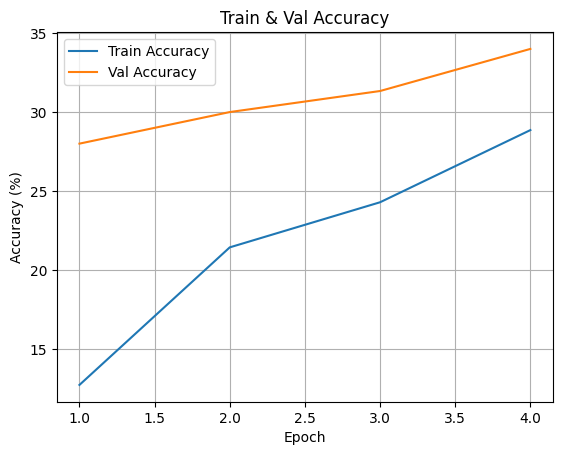

In [3]:
# training model on GTZAN
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import gc
import matplotlib.pyplot as plt

gc.collect()
if device.type == 'mps':
    torch.mps.empty_cache()
    print(torch.mps.current_allocated_memory() / 1024**3, "GB allocated")


model = AudioClassifier(r=5, M=128, input_length=maxlen).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 4
best_val_acc = 0.0


#early stopping
patience = 10
patience = 20
epochs_noimprove = 0

#fyrir plot
train_accuracies = []
val_accuracies = []
def plot_accuracies(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train & Val Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}") # Print epoch number
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch_audio, batch_labels in train_loader:
        batch_audio = batch_audio.unsqueeze(1).to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_audio)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()
    
    train_acc = 100 * train_correct / train_total

    # Validate
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_audio, batch_labels in val_loader:
            batch_audio = batch_audio.unsqueeze(1).to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_audio)
            _, predicted = torch.max(outputs, 1)
            val_total += batch_labels.size(0)
            val_correct += (predicted == batch_labels).sum().item()

            #print("Predicted:", predicted.cpu().tolist())
            #print("True labels:", batch_labels.cpu().tolist())
    
    val_acc = 100 * val_correct / val_total
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {100 * train_correct / train_total:.2f}%, Val Acc: {val_acc:.2f}%")
    
    
    # Save model if this is the best val acc so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_noimprove = 0
        torch.save(model.state_dict(), 'gtzan_model.pth')
        print(f"Saved best model at epoch {epoch+1} with Val Acc: {val_acc:.2f}%")
    else:
        epochs_noimprove += 1

    if epochs_noimprove >= patience:
            print(f"Early stopping triggered on {epoch+1} no improvement.")
            break

plot_accuracies(train_accuracies, val_accuracies)

In [4]:
# Evaluate on GTZAN test set
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for batch_audio, batch_labels in test_loader:
        batch_audio = batch_audio.unsqueeze(1).to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(batch_audio)
        _, predicted = torch.max(outputs, 1)
        test_total += batch_labels.size(0)
        test_correct += (predicted == batch_labels).sum().item()

print(f"GTZAN Test Accuracy: {100 * test_correct / test_total:.2f}%")

GTZAN Test Accuracy: 35.33%


In [5]:
# FMA dataset prep
import pandas as pd
import librosa

# Helper to get FMA file path
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

fma_audio_dir = 'data/fma_small/'
metadata_path = 'fma_metadata/tracks.csv'

# Load metadata
tracks = pd.read_csv(metadata_path, index_col=0, header=[0, 1])

# Filter for small subset, test split, overlapping genres
tracks_small = tracks[tracks['set', 'subset'] == 'small']
overlapping_genres = ['Hip-Hop', 'Pop', 'Rock']
fma_test_overlap = tracks_small[
    (tracks_small['set', 'split'] == 'test') &
    (tracks_small['track', 'genre_top'].isin(overlapping_genres))
]

# Map FMA genres to GTZAN label indices
fma_label_map = {'Hip-Hop': 4, 'Pop': 7, 'Rock': 9}  # hiphop=4, pop=7, rock=9
fma_track_ids = fma_test_overlap.index.tolist()
fma_labels = [fma_label_map[genre] for genre in fma_test_overlap['track', 'genre_top']]

print(f"FMA overlapping test subset: {len(fma_track_ids)} samples")

FMA overlapping test subset: 300 samples


In [6]:
# Define FMA Dataset
class AudioDatasetFMA(Dataset):
    def __init__(self, track_ids, labels, audio_path, duration, sampling_rate):
        self.track_ids = track_ids
        self.labels = labels
        self.audio_path = audio_path
        self.duration = duration
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.track_ids)

    def __getitem__(self, idx):
        track_id = self.track_ids[idx]
        label = self.labels[idx]
        file_path = get_audio_path(self.audio_path, track_id)
        audio_samples, _ = librosa.load(
            file_path, sr=self.sampling_rate, mono=True, duration=self.duration
        )
        audio_samples = torch.from_numpy(audio_samples).float()
        return audio_samples, label

In [7]:
# Evaluate on FMA overlapping test set
fma_test_dataset = AudioDatasetFMA(
    track_ids=fma_track_ids, labels=fma_labels, audio_path=fma_audio_dir,
    duration=duration, sampling_rate=sampling_rate
)

fma_test_loader = DataLoader(fma_test_dataset, batch_size=batch_size, shuffle=False)

# Load trained model
model = AudioClassifier(r=5, M=128, input_length=maxlen).to(device)
model.load_state_dict(torch.load('gtzan_model.pth'))
model.eval()

fma_correct = 0
fma_total = 0
with torch.no_grad():
    for batch_audio, batch_labels in fma_test_loader:
        batch_audio = batch_audio.unsqueeze(1).to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(batch_audio)
        _, predicted = torch.max(outputs, 1)
        fma_total += batch_labels.size(0)
        fma_correct += (predicted == batch_labels).sum().item()

print(f"FMA Overlapping Test Accuracy: {100 * fma_correct / fma_total:.2f}%")

FMA Overlapping Test Accuracy: 15.33%


In [ ]:
# Here we start transfer learning on FMA Dataset
# Dataset prep for FMA for full 8 genres
import pandas as pd
import librosa

# Helper to get FMA file path
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

fma_audio_dir = 'data/fma_small_wav/'
metadata_path = 'fma_metadata/tracks.csv'

tracks = pd.read_csv(metadata_path, index_col=0, header=[0, 1])

# Filter for small subset
tracks_small = tracks[tracks['set', 'subset'] == 'small']

# Get unique genres and map to 0-7
fma_genres = tracks_small['track', 'genre_top'].unique()
fma_genres = sorted([g for g in fma_genres if pd.notna(g)])  # Remove any NaN
fma_label_map = {genre: idx for idx, genre in enumerate(fma_genres)}
print(f"FMA genres: {fma_genres}")
print(f"FMA label map: {fma_label_map}")

# Train split
fma_train = tracks_small[tracks_small['set', 'split'] == 'training']
fma_train_track_ids = fma_train.index.tolist()
fma_train_labels = [fma_label_map[genre] for genre in fma_train['track', 'genre_top']]

# Test split
fma_test = tracks_small[tracks_small['set', 'split'] == 'test']
fma_test_track_ids = fma_test.index.tolist()
fma_test_labels = [fma_label_map[genre] for genre in fma_test['track', 'genre_top']]

print(f"FMA train: {len(fma_train_track_ids)} samples")
print(f"FMA test: {len(fma_test_track_ids)} samples")

FMA genres: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
FMA label map: {'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3, 'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}
FMA train: 6400 samples
FMA test: 800 samples


In [9]:
import os
import subprocess

fma_mp3_dir = 'data/fma_small/'
fma_wav_dir = 'data/fma_small_wav/'

# Create WAV dir if not exists
os.makedirs(fma_wav_dir, exist_ok=True)

# Full path to ffmpeg.exe
ffmpeg_path = 'C:/ffmpeg/bin/ffmpeg.exe'

# Walk through MP3 dir and convert each MP3 to WAV
for root, subdirs, files in os.walk(fma_mp3_dir):
    for fname in files:
        if fname.endswith('.mp3'):
            mp3_path = os.path.join(root, fname)
            relative_path = os.path.relpath(root, fma_mp3_dir)
            wav_root = os.path.join(fma_wav_dir, relative_path)
            os.makedirs(wav_root, exist_ok=True)
            wav_path = os.path.join(wav_root, fname.replace('.mp3', '.wav'))
            
            # Skip if WAV already exists
            if os.path.exists(wav_path):
                print(f"Skipped (already exists): {wav_path}")
                continue
            
            # Call FFmpeg for conversion
            cmd = [ffmpeg_path, '-i', mp3_path, '-ar', '22050', '-ac', '1', wav_path]
            result = subprocess.call(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
            
            if result == 0:
                print(f"Converted: {mp3_path} to {wav_path}")
            else:
                print(f"Error converting {mp3_path} (code {result})—check FFmpeg path or file permissions.")

print("Conversion complete. Use fma_wav_dir for loading.")

Skipped (already exists): data/fma_small_wav/000\000002.wav
Skipped (already exists): data/fma_small_wav/000\000005.wav
Skipped (already exists): data/fma_small_wav/000\000010.wav
Skipped (already exists): data/fma_small_wav/000\000140.wav
Skipped (already exists): data/fma_small_wav/000\000141.wav
Skipped (already exists): data/fma_small_wav/000\000148.wav
Skipped (already exists): data/fma_small_wav/000\000182.wav
Skipped (already exists): data/fma_small_wav/000\000190.wav
Skipped (already exists): data/fma_small_wav/000\000193.wav
Skipped (already exists): data/fma_small_wav/000\000194.wav
Skipped (already exists): data/fma_small_wav/000\000197.wav
Skipped (already exists): data/fma_small_wav/000\000200.wav
Skipped (already exists): data/fma_small_wav/000\000203.wav
Skipped (already exists): data/fma_small_wav/000\000204.wav
Skipped (already exists): data/fma_small_wav/000\000207.wav
Skipped (already exists): data/fma_small_wav/000\000210.wav
Skipped (already exists): data/fma_small

In [10]:
import scipy.io.wavfile as wav

# Helper to get FMA file path
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.wav')

class AudioDatasetFMA(Dataset):
    def __init__(self, track_ids, labels, audio_path, duration, sampling_rate, is_train=False):
        self.track_ids = track_ids
        self.labels = labels
        self.audio_path = audio_path
        self.duration = duration
        self.sampling_rate = sampling_rate
        self.is_train = is_train

    def __len__(self):
        return len(self.track_ids)

    def __getitem__(self, idx):
        track_id = self.track_ids[idx]
        label = self.labels[idx]
        file_path = get_audio_path(self.audio_path, track_id)
        
        try:
            audio_samples, _ = librosa.load(
                file_path, sr=self.sampling_rate, mono=True, duration=self.duration
            )
        except FileNotFoundError as e:
            print(f"Missing file: {file_path} - using dummy data")
            audio_samples = np.zeros(int(self.sampling_rate * self.duration), dtype=np.float32)  # Dummy to avoid batch error
        except Exception as e:
            print(f"Error loading {file_path}: {e} - using dummy data")
            audio_samples = np.zeros(int(self.sampling_rate * self.duration), dtype=np.float32)

        # Enforce length after loading
        target_len = int(self.sampling_rate * self.duration)
        if len(audio_samples) > target_len:
            audio_samples = audio_samples[:target_len]
        elif len(audio_samples) < target_len:
            audio_samples = np.pad(audio_samples, (0, target_len - len(audio_samples)), mode='constant')

        # Apply random augmentations if training
        if self.is_train and np.random.rand() < 0.5:
            # Pitch shift (preserves length)
            audio_samples = librosa.effects.pitch_shift(audio_samples, sr=self.sampling_rate, n_steps=np.random.uniform(-2, 2))

            # Time stretch (changes length, so stretch then resample to original length)
            original_len = len(audio_samples)
            rate = np.random.uniform(0.8, 1.2)
            stretched = librosa.effects.time_stretch(audio_samples, rate=rate)
            audio_samples = librosa.resample(stretched, orig_sr=self.sampling_rate, target_sr=self.sampling_rate * (original_len / len(stretched)))

            # Enforce length after time stretch/resample (fix artifacts)
            if len(audio_samples) > original_len:
                audio_samples = audio_samples[:original_len]
            elif len(audio_samples) < original_len:
                audio_samples = np.pad(audio_samples, (0, original_len - len(audio_samples)), mode='constant')

            # Add noise
            noise = np.random.randn(len(audio_samples)) * 0.005
            audio_samples += noise

            # Clip
            audio_samples = np.clip(audio_samples, -1, 1)

        audio_samples = torch.from_numpy(audio_samples).float()
        return audio_samples, label

In [11]:
# Create FMA loaders
fma_batch_size = 8

fma_train_dataset = AudioDatasetFMA(
    track_ids=fma_train_track_ids, labels=fma_train_labels, audio_path=fma_audio_dir,
    duration=duration, sampling_rate=sampling_rate, is_train=True
)

fma_test_dataset = AudioDatasetFMA(
    track_ids=fma_test_track_ids, labels=fma_test_labels, audio_path=fma_audio_dir,
    duration=duration, sampling_rate=sampling_rate, is_train=False
)

fma_train_loader = DataLoader(fma_train_dataset, batch_size=fma_batch_size, shuffle=True)
fma_test_loader = DataLoader(fma_test_dataset, batch_size=fma_batch_size, shuffle=False)

C:\Users\brynj\AppData\Local\Temp\ipykernel_25444\1166448749.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Add for mixed precision


Epoch 1


C:\Users\brynj\AppData\Local\Temp\ipykernel_25444\1166448749.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision for forward
C:\Users\brynj\AppData\Local\Temp\ipykernel_25444\394729672.py:26: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_samples, _ = librosa.load(
C:\Users\brynj\AppData\Roaming\Python\Python313\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Missing file: data/fma_small_wav/133\133297.wav - using dummy data
Missing file: data/fma_small_wav/099\099134.wav - using dummy data
Missing file: data/fma_small_wav/108\108925.wav - using dummy data


C:\Users\brynj\AppData\Local\Temp\ipykernel_25444\1166448749.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Optional for val, but speeds up


Epoch 1/4, Train Loss: 2.0229, Train Acc: 20.27%, Val Acc: 26.38%
Saved best model at epoch 1 with Val Acc: 26.38%
Epoch 2
Missing file: data/fma_small_wav/133\133297.wav - using dummy data
Missing file: data/fma_small_wav/108\108925.wav - using dummy data
Missing file: data/fma_small_wav/099\099134.wav - using dummy data
Epoch 2/4, Train Loss: 1.9448, Train Acc: 23.91%, Val Acc: 31.12%
Saved best model at epoch 2 with Val Acc: 31.12%
Epoch 3
Missing file: data/fma_small_wav/099\099134.wav - using dummy data
Missing file: data/fma_small_wav/108\108925.wav - using dummy data
Missing file: data/fma_small_wav/133\133297.wav - using dummy data
Epoch 3/4, Train Loss: 1.9238, Train Acc: 25.80%, Val Acc: 31.75%
Saved best model at epoch 3 with Val Acc: 31.75%
Epoch 4
Missing file: data/fma_small_wav/108\108925.wav - using dummy data
Missing file: data/fma_small_wav/133\133297.wav - using dummy data
Missing file: data/fma_small_wav/099\099134.wav - using dummy data
Epoch 4/4, Train Loss: 1.911

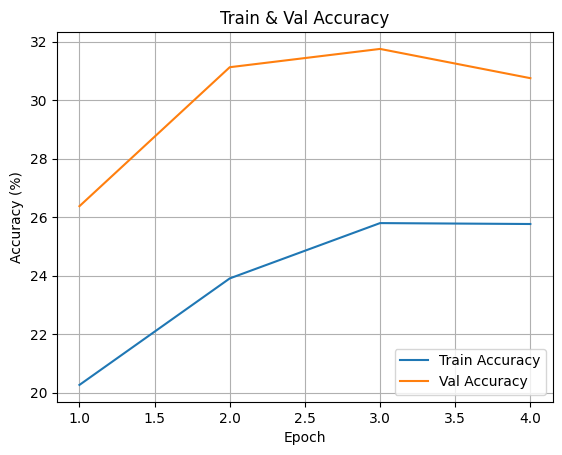

In [12]:
from torch.cuda.amp import GradScaler, autocast

# Transfer learning
pretrained_model = AudioClassifier(r=5, kernel_size=5, M=128, input_length=int(22050 * duration)).to(device)
pretrained_model.load_state_dict(torch.load('gtzan_model.pth'))

# Freeze early layers
for param in pretrained_model.blocks.parameters():
    param.requires_grad = False

# Replace final layer for 8 classes
pretrained_model.fc2 = nn.Linear(pretrained_model.fc1.out_features, len(fma_genres))  # M to 8

# Move to device
pretrained_model = pretrained_model.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=0.0001)

criterion = nn.CrossEntropyLoss()

# Train on FMA
num_epochs = 4
best_val_acc = 0.0
patience = 10
epochs_no_improve = 0
train_accuracies = []
val_accuracies = []

scaler = GradScaler()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    pretrained_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch_audio, batch_labels in fma_train_loader:
        batch_audio = batch_audio.unsqueeze(1).to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = pretrained_model(batch_audio)
            loss = criterion(outputs, batch_labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()
    
    train_acc = 100 * train_correct / train_total

    # Validate on FMA test
    pretrained_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_audio, batch_labels in fma_test_loader:
            batch_audio = batch_audio.unsqueeze(1).to(device)
            batch_labels = batch_labels.to(device)
            with autocast():
                outputs = pretrained_model(batch_audio)
            _, predicted = torch.max(outputs, 1)
            val_total += batch_labels.size(0)
            val_correct += (predicted == batch_labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(fma_train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(pretrained_model.state_dict(), 'fma_model.pth')
        print(f"Saved best model at epoch {epoch+1} with Val Acc: {val_acc:.2f}%")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered on {epoch+1} no improvement.")
        break

plot_accuracies(train_accuracies, val_accuracies)